In [1]:
import torch
from transformers import AutoTokenizer

import shap
import matplotlib.pyplot as plt

from error_analysis_TRC import load_local_model, prepare_data

/home/cc/venv/rora_venv/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/cc/venv/rora_venv/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks,

In [2]:
ASSIGN_WEIGHT = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
model_name = 'roberta-large'

model_path = '/home/cc/rora_tesi_new/log/log_TRC/roberta-large/bertweet-seq/20_epoch/data/True_weight/42_seed/saved-model/pytorch_model.bin'
config_path = '/home/cc/rora_tesi_new/log/log_TRC/roberta-large/bertweet-seq/20_epoch/data/True_weight/42_seed/saved-model/config.json'

In [3]:
train_data_path = '/home/cc/rora_tesi_new/data/train.p'
test_data_path = '/home/cc/rora_tesi_new/data/test.p'

need_columns = ['tweet','tweet_tokens', 'sentence_class']

tweet_test, tweet_tokens_test, binary_test = prepare_data(test_data_path, need_columns)




In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_name, normalization = True)
model = load_local_model(model_path, config_path, device, model_name)
model = model.to(device)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
labels = sorted(model.config.label2id, key=model.config.label2id.get)
print(labels)
labels = [x.split('_')[1] for x in labels]
print(labels)

['LABEL_0', 'LABEL_1']
['0', '1']


In [48]:
torch.cuda.empty_cache()

In [6]:
# input della funzione una lista di stringhe

def f(x):
    # x = [tweet_test[0]]
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=128, truncation=True) for v in x]).to(device)
    # print('tv',tv.shape)
    attention_mask = (tv!=0).type(torch.int64).to(device)
    # print('atte',attention_mask.shape)
    model.eval()
    with torch.no_grad():
        outputs = model(tv, attention_mask, class_weight=None)
    # print(outputs)

    return outputs['logits']

In [7]:
f([tweet_test[0]])

tensor([[ 2.2750, -1.6938]], device='cuda:0')

In [8]:
inputs = []
for i in range(10):
    inputs.append(tweet_test[i])


In [9]:
# explainer = shap.Explainer(f, tokenizer, output_names=labels)
explainer = shap.Explainer(f, masker = tokenizer)


In [10]:
shap_values = explainer(inputs)

Partition explainer: 11it [00:39,  4.42s/it]                        


In [11]:
shap_values.shape

(10, None, 2)

In [135]:
# shap_values = shap_values[:,:,1]
# shap_values.shape

(1, 36)

In [12]:
import string

token_dict = {}
def create_token_dict(shap_values):
    val = [shap_values[i] for i in range(len(shap_values))]
    for el in val:
        for i in range(len(el)-1):
            token = el[i].data
            # print(token)
            token = token.strip()
            if token not in string.punctuation and token != 'USER' and token != 'HTTPURL':
                # print(token)
                shap_val = el[i].values
                pos = shap_val[1]
                if token not in token_dict.keys():
                    token_dict[token] = pos
                else:
                    token_dict[token] += pos
    return token_dict
                # PRENDI SOLO VAL RELATIVO ALLA CLASSE POSITIVA
 

    

In [17]:
token_dict = create_token_dict(shap_values)

In [21]:
import operator
sorted = sorted(token_dict.items(), key = lambda x:x[1], reverse = True)

TypeError: 'list' object is not callable

In [22]:
sorted_d = dict(sorted)

In [23]:
def get_n(n,token_dict):
    tmp = {}
    for i,k,v in zip(range(n), token_dict.keys(), token_dict.values()):
        tmp[k] = v
    return tmp


In [24]:
to_plot = get_n(20, sorted_d)

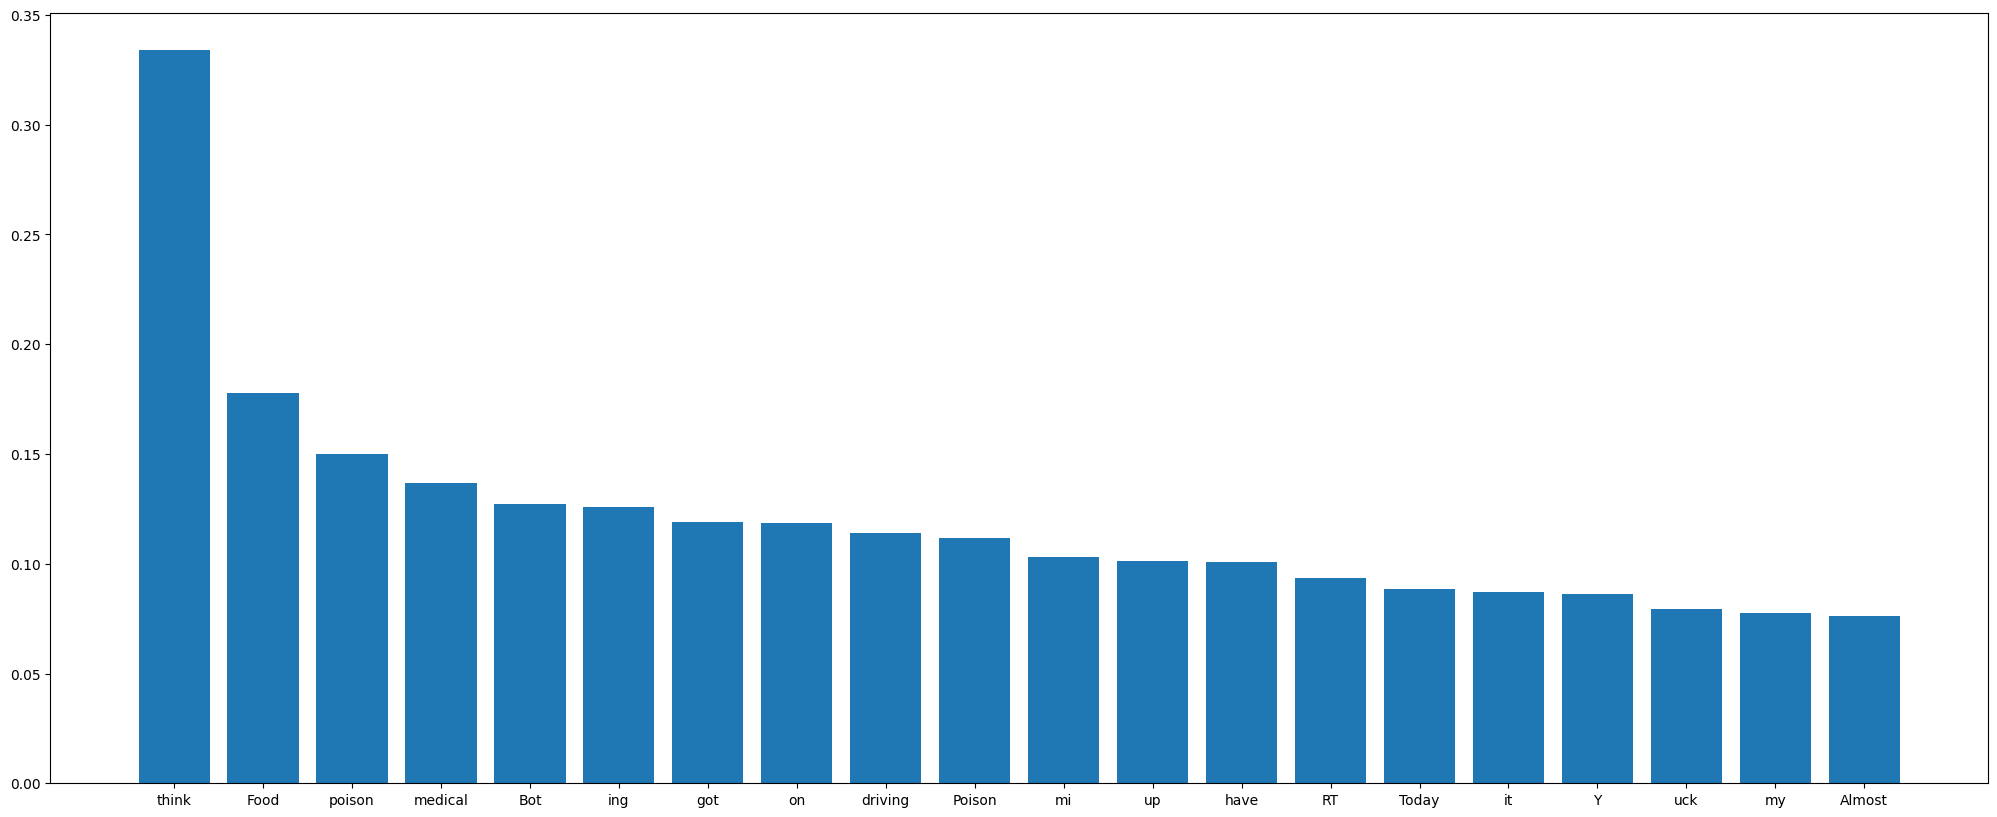

In [25]:
plt.figure(figsize=(25,10))
plt.bar(range(len(to_plot)), list(to_plot.values()), tick_label=list(to_plot.keys()))
plt.show()

In [95]:
[shap_values[i].values.shape for i in range(len(shap_values))]


[(36, 2), (35, 2), (32, 2)]

In [232]:
# per questo grafico prendi solo scores della classe positiva
# e solo gli scores di un tweet
# shap_values[:,:,1]

# input = [tweet_test[3]]
# sv = explainer(input)
# sv = sv[:,:,1]
# shap.plots.waterfall(sv[0], max_display=20)